<a href="https://colab.research.google.com/github/renan-estatistica/notebooksAulaRedesNeuraisInpe/blob/main/Projeto_3_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoders Experiments

Neste projeto iremos realizar uma série de experimentos com dados afim de fixar o aprendizado sobre variational autoencoders vistos em aula. Iremos aplicar o método em dois conjuntos de dados distintos, sendo o primeiro um experimento mais simples com dados de fácil acesso e interpretação para a compreenssão teórica do sampling gerado pelas distribuições latentes do autoencoder e o segundo uma aplicação utilizando a base mnist com a utilização de CNN para o processamento das imagens antes do modelo de encoder.

# Conjunto 1: Autoencoders em Problemas de Classificação

Neste primeiro conjunto iremos utilizar a base de dados *Stellar Classification Dataset - SDSS17*, esta base disponibilizada propõe o desenvolvimento de um modelo de classificação para identificação de objetos estelares, sendo os objetos (Quasar, Star, Galaxy). Os inputs fornecidos são variáveis relacionadas ao espectro observado do objeto estelar como por exemplo *redshift, filtros de cor do espectro*.

Neste tipo de problema iremos observar que parte das variáveis são altamente correlacionadas linearmente, além de que, a composição das variáveis conjutamente pode auxiliar no processo de modelagem. 

Iremos aplicar três métodos neste primeiro conjunto de dados:
* Ajuste de um modelo com os dados puros sem nenhuma seleção de variáveis;
* Autoencoder simples para verificação e comparação dos resultados, buscando melhora nos resultados;
* Variational Autoencoder para gerar novos conjuntos de dados buscando uma base com menor ruído e melhor ajuste dos dados.

Iremos utilizar como modelo de comparação o **Xgboost**, pois este consegue obter resultados interessantes sem a necessidade da otimização de vários hiperparâmetros e a facilidade de utilização já que o objetivo principal é a comparação do resultados ao se processar os dados utilizando autoencoders.

## Biblioteca, Leitura e Processamento dos Dados

In [ ]:
# dados
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Redes Neurais
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
# xgboost
from xgboost import XGBClassifier
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
dados = pd.read_csv("star_classification.csv")

In [ ]:
dados.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [ ]:
# remoção das colunas de identificação dos itens

dados.drop(columns = ["obj_ID","run_ID","rerun_ID","cam_col","field_ID","spec_obj_ID","spec_obj_ID","plate","MJD","fiber_ID"],
           inplace = True)

In [ ]:
dados.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [ ]:
# reorganizar base aleatoriamente

dados = dados.sample(frac=1).reset_index(drop=True)

In [ ]:
# correlação das variáveis
corr = dados.corr()
corr.style.background_gradient(cmap='coolwarm')

,alpha,delta,u,g,r,i,z,redshift
alpha,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,0.001667
delta,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,0.031638
u,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.014309
g,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.022954
r,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.433241
i,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.492383
z,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.030380
redshift,0.001667,0.031638,0.014309,0.022954,0.433241,0.492383,0.030380,1.000000


podemos verificar que parte das variáveis como (z e u, z e g, redshift e r) possuem uma correlação linear representativa.

In [ ]:
# separando base de treino e teste
entradas = dados.drop(columns=["class"])
saida = dados.loc[:,"class"]

x, x_teste, y, y_teste = train_test_split(entradas,saida,test_size=0.1,train_size=0.9,stratify=saida)

In [ ]:
print(y.value_counts(normalize = True))
print(y_teste.value_counts(normalize = True))

GALAXY    0.594444
STAR      0.215944
QSO       0.189611
Name: class, dtype: float64
GALAXY    0.5945
STAR      0.2159
QSO       0.1896
Name: class, dtype: float64


In [ ]:
# normalizando os dados conforme min/max criterion
max_treino = x.max()
min_treino = x.min()

x_treino_normalizado = (x-min_treino)/(max_treino-min_treino)
x_teste_normalizado = (x_teste-min_treino)/(max_treino-min_treino)

In [ ]:
# convertendo dados para numpy

x_treino_normalizado_np = x_treino_normalizado.to_numpy()
x_teste_normalizado_np = x_teste_normalizado.to_numpy()

In [ ]:
n_inputs = x_treino_normalizado.shape[1]

In [ ]:
n_inputs

8

## Gerando o Modelo XGBoost sem processamento de dados

Agora que o processamento básico das variáveis foi realizado para o ínicio da modelagem, iremos desenvolver o modelo de SVM e obter os resultados do ajuste.

In [ ]:
# cria o objeto contendo o modelo
clf = XGBClassifier(random_state=0)

# treino o modelo xgboost
clf.fit(x_treino_normalizado, y)

XGBClassifier(objective='multi:softprob')

In [ ]:
# faz predicoes para o conjunto de teste
y_pred = clf.predict(x_teste_normalizado)

In [ ]:
# Avalia a acurácia do Modelo

accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 97.39%


Verificamos que mesmo com os dados puros, foi possível obter bons resultados com o ajuste do modelo, vamos verificar se com o autoencoder simples podemos obter um resultado próximo ou melhor.

## Criando o Autoencoder Simples

In [ ]:
model = Sequential()
model.add(Dense(2, input_dim=n_inputs, activation= "relu"))
model.add(Dense(n_inputs,activation = "linear"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 2)                 18        
                                                                 
 dense_17 (Dense)            (None, 8)                 24        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='mse')

In [ ]:
modelo_1 = model.fit(x_treino_normalizado_np,
                     x_treino_normalizado_np,
                     batch_size = 20,
                     epochs = 30,
                     validation_data= (x_teste_normalizado_np,x_teste_normalizado_np))

Train on 90000 samples, validate on 10000 samples
Epoch 1/30
89380/90000 [============================>.] - ETA: 0s - loss: 0.0427

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


90000/90000 [==============================] - 5s 55us/sample - loss: 0.0425 - val_loss: 0.0138
Epoch 2/30
90000/90000 [==============================] - 5s 57us/sample - loss: 0.0101 - val_loss: 0.0079
Epoch 3/30
90000/90000 [==============================] - 4s 49us/sample - loss: 0.0078 - val_loss: 0.0077
Epoch 4/30
90000/90000 [==============================] - 4s 48us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 5/30
90000/90000 [==============================] - 4s 48us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 6/30
90000/90000 [==============================] - 4s 49us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 7/30
90000/90000 [==============================] - 4s 48us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 8/30
90000/90000 [==============================] - 4s 48us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 9/30
90000/90000 [==============================] - 5s 51us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 10/30
90000/90000 [=======================

In [ ]:
# erro do Modelo
mse = model.evaluate(x_teste_normalizado_np, x_teste_normalizado_np, verbose=0)
print("Erro Quadrático Médio do Ajuste do Modelo:",mse)

Erro Quadrático Médio do Ajuste do Modelo: 0.007708474855124951


In [ ]:
# transformando as as observações
predicted_results = model.predict(x_treino_normalizado_np)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# transformando o conjunto de teste também
predicted_test_results = model.predict(x_teste_normalizado_np)

In [ ]:
# cria o objeto contendo o modelo
clf_encoder = XGBClassifier(random_state=0)

# treino o modelo xgboost
clf_encoder.fit(predicted_results, y)

XGBClassifier(objective='multi:softprob')

In [ ]:
# faz predicoes para o conjunto de teste
y_pred_encoder = clf_encoder.predict(predicted_test_results)

In [ ]:
# Avalia a acurácia do Modelo

accuracy = accuracy_score(y_teste, y_pred_encoder)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 60.72%


Podemos verificar que mesmo o autoencoder simples tendo bons resultados no seu ajuste, ainda é passível de perda de informações o que arruína os resultados do modelo de classificação.

## Variational Autoencoder

Com a proposta do variational autoencoder buscamos obter resultados mais consistentes para a reconstrução dos dados a partir da distribuição das variáveis.

## Criando o Encoder do VAE

In [ ]:
input_data = tensorflow.keras.layers.Input(shape=(n_inputs))
encoder = Dense(2, activation='relu')(input_data)

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random
 
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 2)            18          ['input_1[0][0]']                
                                                                                                  
 mean (Dense)                   (None, 2)            6           ['dense_18[0][0]']               
                                                                                                  
 log_variance (Dense)           (None, 2)            6           ['dense_18[0][0]']               
                                                                                              

## Criando o Decoder do VAE

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder_output = tensorflow.keras.layers.Dense(n_inputs)(decoder_input)

In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 8)                 24        
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


## Montando o VAE

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 model (Functional)          (None, 2)                 30        
                                                                 
 model_1 (Functional)        (None, 8)                 24        
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


## Função KL de perda

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*32*32
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Compilando o modelo

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 model (Functional)          (None, 2)                 30        
                                                                 
 model_1 (Functional)        (None, 8)                 24        
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo = autoencoder.fit(x_treino_normalizado_np,
                         x_treino_normalizado_np,
                         epochs=30,
                         batch_size=20,
                         validation_data=(x_teste_normalizado_np, x_teste_normalizado_np))

Train on 90000 samples, validate on 10000 samples
Epoch 1/30
89580/90000 [============================>.] - ETA: 0s - loss: 73.2166

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


90000/90000 [==============================] - 6s 66us/sample - loss: 72.9547 - val_loss: 17.4506
Epoch 2/30
90000/90000 [==============================] - 6s 62us/sample - loss: 17.3922 - val_loss: 15.2591
Epoch 3/30
90000/90000 [==============================] - 6s 63us/sample - loss: 9.7502 - val_loss: 9.1243
Epoch 4/30
90000/90000 [==============================] - 6s 67us/sample - loss: 9.1035 - val_loss: 9.0590
Epoch 5/30
90000/90000 [==============================] - 7s 75us/sample - loss: 9.0885 - val_loss: 9.0518
Epoch 6/30
90000/90000 [==============================] - 6s 64us/sample - loss: 9.0844 - val_loss: 9.0749
Epoch 7/30
90000/90000 [==============================] - 8s 86us/sample - loss: 9.0839 - val_loss: 9.0641
Epoch 8/30
90000/90000 [==============================] - 8s 85us/sample - loss: 9.0805 - val_loss: 9.0412
Epoch 9/30
90000/90000 [==============================] - 6s 63us/sample - loss: 9.0782 - val_loss: 9.0607
Epoch 10/30
90000/90000 [===================

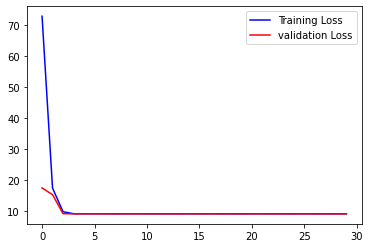

In [ ]:
plt.plot(modelo.history['loss'], color='b', label="Training Loss")
plt.plot(modelo.history['val_loss'], color='r', label="validation Loss")
plt.rcParams['figure.figsize'] = (20, 10)
plt.legend()
plt.show()

In [ ]:
# transformando as as observações
predicted_results_vae = autoencoder.predict(x_treino_normalizado_np)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# transformando o conjunto de teste também
predicted_test_results_vae = autoencoder.predict(x_teste_normalizado_np)

In [ ]:
# cria o objeto contendo o modelo
clf_encoder_vae = XGBClassifier(random_state=0)

# treino o modelo xgboost
clf_encoder_vae.fit(predicted_results_vae, y)

XGBClassifier(objective='multi:softprob')

In [ ]:
# faz predicoes para o conjunto de teste
y_pred_encoder_vae = clf_encoder_vae.predict(predicted_test_results_vae)

In [ ]:
# Avalia a acurácia do Modelo

accuracy = accuracy_score(y_teste, y_pred_encoder_vae)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 59.61%


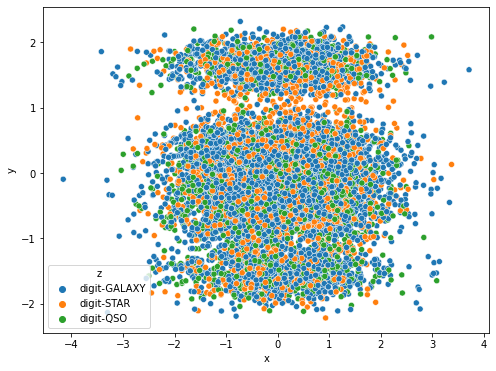

In [ ]:
# distribuicao das classes na fase do encoder latente
x = []
y_l = []
z = []
for i in range(y_teste.shape[0]):
    z.append(y_teste.to_numpy()[i])
    op = encoder_model.predict(np.array([x_teste_normalizado_np[i]]))
    x.append(op[0][0])
    y_l.append(op[0][1])
df = pd.DataFrame()
df['x'] = x
df['y'] = y_l
df['z'] = ["digit-"+str(k) for k in z]
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

## Resultados Obtidos

Podemos verificar que mesmo aplicar o variational autoencoder os resultados não foram satisfatórios, possívelmente a separação definida pelo modelo não seja ideal para as variáveis, ou até mesmo, o conjunto não permite uma separação bem definida para a classificação ideal dos objetos estelares.

# Conjunto 2 : Imagens Mnist

Conjunto de imagens coloridas utilizada em problemas de classificação para contendo 10 tipos diferentes de digitos, são disponibilizadas 60000 imagens em resolução 28x28. Conjunto disponível no pacote keras e de acesso na página: [Mnist Digits Classification ](https://keras.io/api/datasets/mnist/ )

## Bibliotecas, Leitura e Processamentos dos Dados

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import tensorflow
from tensorflow.keras.datasets import mnist
tensorflow.compat.v1.disable_eager_execution()
import cv2
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# carregando a base de dados que será utilizada
(imagens_treino, labels_treino), (imagens_teste, labels_teste) = mnist.load_data()

11501568/11490434 [==============================] - 2s 0us/step


In [ ]:
# dimensao das bases
print('Dimensão bases de treino: X=%s, y=%s' % (imagens_treino.shape, labels_treino.shape))
print('Dimensão bases de teste: X=%s, y=%s' % (imagens_teste.shape, labels_teste.shape))

Dimensão bases de treino: X=(60000, 28, 28), y=(60000,)
Dimensão bases de teste: X=(10000, 28, 28), y=(10000,)


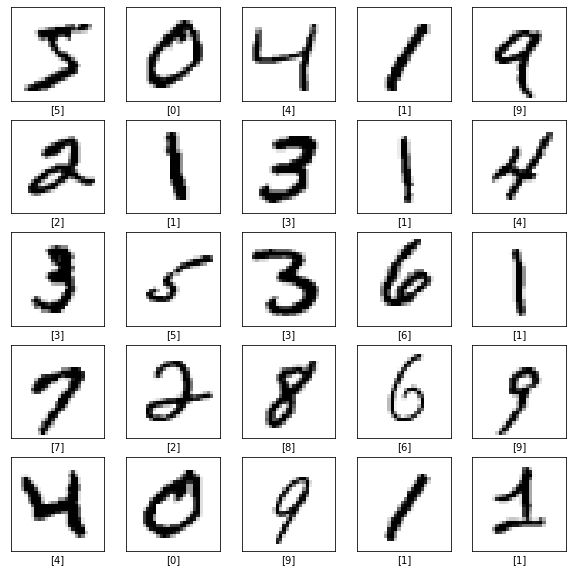

In [ ]:
# apresentando algumas das imagens
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagens_treino[i], cmap=plt.cm.binary)
  plt.xlabel([labels_treino[i]])

plt.show()

In [ ]:
# iremos normalizar a base de treino e teste para escala [0,1] para melhor performance do modelo
# e para que o mesmo consiga extrair as curvas características dos itens das imagens

imagens_treino  = imagens_treino/255
imagens_teste  = imagens_teste/255


In [ ]:
# iremos redimensionar os dados adicionando uma dimensão extra relacionada a escala cinza
imagens_treino = np.reshape(imagens_treino, (60000, 28, 28, 1))
imagens_teste = np.reshape(imagens_teste, (10000, 28, 28, 1))
print(imagens_treino.shape, imagens_teste.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Criando o Encoder do Modelo

In [ ]:
input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))
encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random
 
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   1664        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 12, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 10, 10, 64)   36928       ['max_pooling2d[0][0]']          
                                                                                              

## Criando o Decoder do Modelo

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)
 
decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 3, 3, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 5, 5, 64)         36928     
 ranspose)                                                       
                                                                 
 up_sampling2d_2 (UpSampling  (None, 10, 10, 64)       0   

## Montando o VAE

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 2)                 57652     
                                                                 
 model_2 (Functional)        (None, 28, 28, 1)         112577    
                                                                 
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


## Função KL de perda

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*32*32
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Compilando o modelo

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 2)                 57652     
                                                                 
 model_2 (Functional)        (None, 28, 28, 1)         112577    
                                                                 
Total params: 170,229
Trainable params: 170,229
Non-trainable params: 0
_________________________________________________________________


## Treinando o modelo

In [ ]:
autoencoder.fit(imagens_treino, imagens_treino, epochs=5, batch_size=500, validation_data=(imagens_teste, imagens_teste))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 212s 4ms/sample - loss: 66.8760 - val_loss: 58.4220
Epoch 2/5
60000/60000 [==============================] - 221s 4ms/sample - loss: 55.6996 - val_loss: 53.8602
Epoch 3/5
60000/60000 [==============================] - 215s 4ms/sample - loss: 52.5900 - val_loss: 51.3487
Epoch 4/5
60000/60000 [==============================] - 208s 3ms/sample - loss: 50.9705 - val_loss: 50.3272
Epoch 5/5
60000/60000 [==============================] - 214s 4ms/sample - loss: 49.9466 - val_loss: 49.5444


## Resultados Obtidos

Imagens Teste Reais


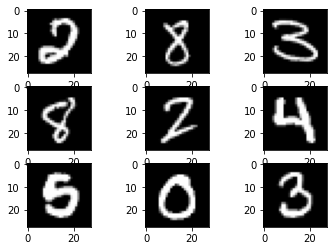

Imagens Teste Reconstruídas


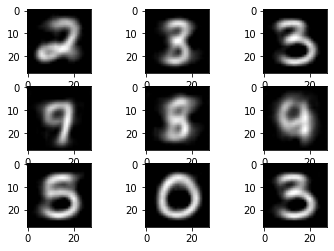

In [ ]:
offset=400
print ("Imagens Teste Reais")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(imagens_teste[i+offset,:,:, -1], cmap='gray')
plt.show()
# Reconstructed Images
print ("Imagens Teste Reconstruídas")
for i in range(9):
    plt.subplot(330 + 1 + i)

    output = autoencoder.predict(np.array([imagens_teste[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

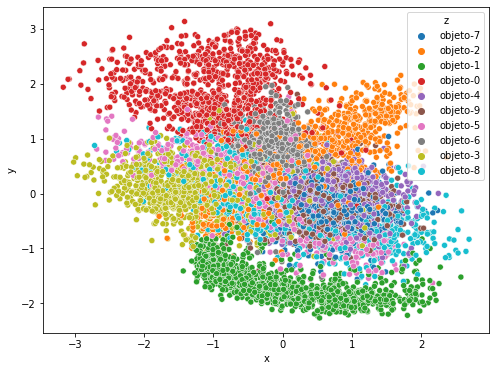

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(labels_teste[i])
    op = encoder_model.predict(np.array([imagens_teste[i]]))
    x.append(op[0][0])
    y.append(op[0][1])
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["objeto-"+str(k) for k in z]
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

# Referências 

* [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
* [Autoencoders 1](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Autoencoders 2](https://medium.com/analytics-vidhya/building-the-simplest-auto-encoder-in-keras-b7f21f33bef0)
* [Variational Autoencoders 1 ](https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb)
* [Variational Autocenders 2](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/)
* [Variational Autoencoders 3](https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/)
* [Tensorflow Variational Autoencoders](https://www.tensorflow.org/tutorials/generative/cvae)